In [26]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prototype_dir = os.getcwd()
print(prototype_dir)

parent = os.path.dirname(prototype_dir)
parent_dir = os.path.dirname(parent)
sys.path.append(parent_dir)
print(parent_dir)

top_dir = os.path.dirname(parent_dir)
print(top_dir)

data_dir = top_dir + r'\neuroscikit_test_data\sequential_axona_sessions'
print(data_dir)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\prototypes\wave_form_sorter
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\sequential_axona_sessions


In [3]:
from core.data_spikes import (
    SpikeTrain,
    SpikeTrainBatch,
    Spike,
    SpikeCluster,
    SpikeClusterBatch,
)

from x_io.axona.read_tetrode_and_cut import (
    load_spike_train_from_paths,
    _read_cut,
    _format_spikes
)

from core.data_study import (
    Study,
    Event,
    Animal
)

from core.core_utils import (
    make_seconds_index_from_rate
)

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\prototypes\wave_form_sorter
c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit\prototypes\wave_form_sorter


In [4]:
files = os.listdir(data_dir)

test1_34 = []
test1_35 = []
test2_34 = []
test2_35 = []

for f in files:
    if 'Test1' in f and '34' in f:
        test1_34.append(f)
    elif 'Test1' in f and '35' in f:
        test1_35.append(f)
    elif 'Test2' in f and '34' in f:
        test2_34.append(f)
    elif 'Test2' in f and '35' in f:
        test2_35.append(f)

In [5]:
session1 = test1_34
session2 = test2_34

assert len(session1) == len(session2)

session1_tets = []
session2_tets = []

for i in range(len(session1)):
    if 'cut' in session1[i]:
        session1_cut = session1[i]
    if 'cut' in session2[i]:
        session2_cut = session2[i]
    file_session_1 = session1[i]
    file_session_2 = session2[i]
    out1 = file_session_1.split('.')[-1]
    out2 = file_session_2.split('.')[-1]
    if out1.isnumeric() and 'clu' not in file_session_1:
        session1_tets.append(session1[i])
    if out2.isnumeric() and 'clu' not in file_session_2:
        session2_tets.append(session2[i])



In [6]:
session1_cut_path = os.path.join(data_dir, session1_cut)
session1_tet_path = os.path.join(data_dir, session1_tets[0])

session2_cut_path = os.path.join(data_dir, session2_cut)
session2_tet_path = os.path.join(data_dir, session2_tets[0])

In [7]:
# waveforms1 = [[] for i in range(4)]
# for i in range(4):
#     channel, empty_cell, cluster_label = load_spike_train_from_paths(session1_cut_path, session1_tet_path, i+1)
#     cells1 = channel[:empty_cell][1]
#     channel_waveforms = channel[:empty_cell][0][0]
#     # timestamps = channel[:empty_cell][0][1]
#     waveforms1[i] = channel_waveforms

# waveforms1 = np.array(waveforms1)
# waveforms1 = waveforms1.reshape((waveforms1.shape[1], waveforms1.shape[0], waveforms1.shape[2]))

# waveforms2 = [[] for i in range(4)]
# for i in range(4):
#     channel, empty_cell, cluster_label = load_spike_train_from_paths(session2_cut_path, session2_tet_path, i+1)
#     cells2 = channel[:empty_cell][1]
#     channel_waveforms = channel[:empty_cell][0][0]
#     # timestamps = channel[:empty_cell][0][1]
#     waveforms2[i] = channel_waveforms

# waveforms2 = np.array(waveforms2)
# waveforms2 = waveforms2.reshape((waveforms2.shape[1], waveforms2.shape[0], waveforms2.shape[2]))

In [8]:
# add duration
# go overwhich classes use self.timestamp
# make Neuron instead of SpikeCluster. Neuron class more extensible, for now merge SpikeTrain fxns, later will want to ahve 
# summary fxns to see easily if waveform data available or not, maybe make it optional to pass in 
# check combination of inputs, e.g. if waveforms, need timestamps
# e.g. waveforms put in dictionary that holds diff. attributes/stats that can be added to by user --> fxn
# also will ahve to add fxn to check that user can add data to the dict

# look into error raising that doesnt stop code if exists

# spike object --> neuron --> ensemble --> study
# ensemble most complex, holds covariates
# study ensures conssitency across ensembles, e.g. if one ensemble has this attribute then so do other ensembles
# extensible and flexible
# study class has functions to return e.g. sorted ensembles/neurons based on added covariate/added attribute

# inside file loading classes, make spike objects add to ensemble and in batch_load add ensembles to study

# NEw plan: Animal --> Contexts (sess  ions) --> SpikeTrain --> Spike object (event)
# Ensemble --> neuron --> spike object

# new new plan
# Study --> Animal --> Events
# Neuron is attribute of event (e.g. spike belonging to a neuron)
# polymorphism of events would be spikes (also e.g. lfp)
# Ensembles (data structure resulting from group by e.g. spatial, context, maze), can span animal ,session, study


In [9]:
with open(session1_cut_path, 'r') as cut_file1, open(session1_tet_path, 'rb') as tetrode_file1:
    cut_data1 = _read_cut(cut_file1)
    tetrode_data1 = _format_spikes(tetrode_file1)
    # ts, ch1, ch2, ch3, ch4, spikeparam

with open(session2_cut_path, 'r') as cut_file2, open(session2_tet_path, 'rb') as tetrode_file2:
    cut_data2 = _read_cut(cut_file2)
    tetrode_data2 = _format_spikes(tetrode_file2)
    # ts, ch1, ch2, ch3, ch4, spikeparam

In [10]:
sample_length1 =  tetrode_data1[-1]['duration']
sample_rate1 = tetrode_data1[-1]['samples_per_spike']

session_dict1 = {
    'spike_times': tetrode_data1[0].squeeze().tolist(),
    'cluster_labels': cut_data1,
    'ch1': tetrode_data1[1],
    'ch2': tetrode_data1[2],
    'ch3': tetrode_data1[3],
    'ch4': tetrode_data1[4],
}

sample_length2 =  tetrode_data2[-1]['duration']
sample_rate2 = tetrode_data2[-1]['samples_per_spike']

session_dict2 = {
    'spike_times': tetrode_data2[0].squeeze().tolist(),
    'cluster_labels': cut_data2,
    'ch1': tetrode_data2[1],
    'ch2': tetrode_data2[2],
    'ch3': tetrode_data2[3],
    'ch4': tetrode_data2[4],
}

assert sample_length1 == sample_length2
assert sample_rate1 == sample_rate2

study_dict = {
    'sample_length': sample_length1,
    'sample_rate': sample_rate1,
    'animal_ids': ['0']
}

animal_dict = {
    'id': '0',
}

animal_dict[0] = session_dict1
animal_dict[1] = session_dict2

In [41]:
np.array(tetrode_data1[3]).shape

(159055, 50)

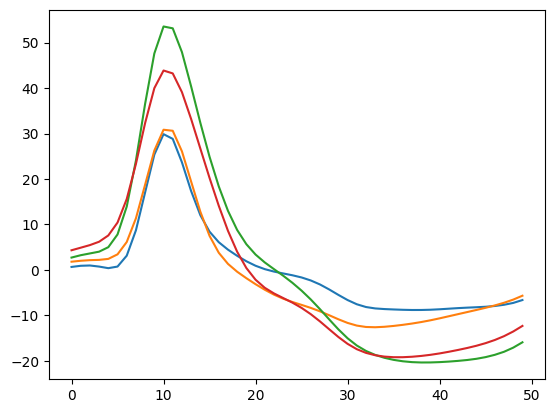

In [47]:
plt.plot(np.mean(tetrode_data1[1], axis=0))
plt.plot(np.mean(tetrode_data1[2], axis=0))
plt.plot(np.mean(tetrode_data1[3], axis=0))
plt.plot(np.mean(tetrode_data1[4], axis=0))

In [11]:
study = Study(study_dict)

In [12]:
study.add_animal(animal_dict)

In [13]:
for animal in study.animals:
    sesssion_data = animal.get_session_data(0)

In [14]:
np.array(animal.agg_waveforms[0]).shape

(4, 159055, 50)

In [48]:
def sort_by_cell(spike_times, cluster_labels, waveforms):

    assert len(spike_times) == len(cluster_labels)

    cells = [[] for i in range(len(spike_times))]
    sorted_waveforms = [[] for i in range(len(spike_times))]

    for i in range(len(spike_times)):
        labels = np.unique(cluster_labels[i])
        # comes in shape (channel count, spike time, nmb samples) but is nested list not numpy
        # want to rearrannge to be (spike time, channel count, nmb sample )
        waves = np.array(waveforms[i]).reshape((len(waveforms[i][0]), len(waveforms[i]),  len(waveforms[i][0][0])))
        for lbl in labels:
            idx = np.where(cluster_labels[i] == lbl)
            cells[i].append(np.array(spike_times[i])[idx])
            sorted_waveforms[i].append(waves[idx,:,:].squeeze())

    return cells, sorted_waveforms


In [138]:
def average_by_cell(waveforms):
    averaged_waveforms = [[] for i in range(len(waveforms))]
    # for each session
    for i in range(len(waveforms)):
        # for each cell
        for j in range(len(waveforms[i])):
            avg = np.mean(waveforms[i][j].squeeze(), axis=0)
            averaged_waveforms[i].append(avg)
    return averaged_waveforms

In [113]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    __author__ = "Marcos Duarte, https://github.com/demotu/BMC"
    __version__ = "1.0.4"
    __license__ = "MIT"

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan - 1, indnan + 1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind] - x[ind - 1], x[ind] - x[ind + 1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                              & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        # _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


In [139]:
def get_peak_amplitudes(waveforms):
    peaks = [[] for i in range(len(waveforms))]
    peak_ids = [[] for i in range(len(waveforms))]
    for i in range(len(waveforms)):
        for j in range(len(waveforms[i])):
            cell_peak = []
            cell_peak_id = []
            for k in range(len(waveforms[i][j])):
                cell_peak.append(np.max(waveforms[i][j][k]))
                cell_peak_id.append(np.argmax(waveforms[i][j][k]))
            peaks[i].append(cell_peak)
            peak_ids[i].append(cell_peak_id)
    return peaks, peak_ids

In [140]:
def sort_waveforms_by_sesssion(animal: Animal):
    cells, waveforms = sort_by_cell(animal.agg_spike_times, animal.agg_cluster_labels, animal.agg_waveforms)

    waveforms = average_by_cell(waveforms)

    # peaks = [[] for i in range(len(waveforms))]
    # for i in range(len(waveforms)):
    #     for j in range(len(waveforms[i])):
    #         cell_peak = []
    #         for k in range(len(waveforms[i][j])):
    #             cell_peak.append(detect_peaks(waveforms[i][j][k]))
    #         peaks[i].append(cell_peak)

    peaks, peak_ids = get_peak_amplitudes(waveforms)


In [141]:

cells, waveforms = sort_by_cell(animal.agg_spike_times, animal.agg_cluster_labels, animal.agg_waveforms)
waveforms = average_by_cell(waveforms)
peaks, peak_ids = get_peak_amplitudes(waveforms)


In [143]:
peak_ids

[[[39.833791968949235,
   39.83019111080788,
   39.873537862075764,
   39.68194946669396],
  [36.575175175175175, 35.9028028028028, 35.9, 35.42202202202202],
  [44.293103448275865,
   43.00574712643678,
   41.14942528735632,
   44.229885057471265],
  [40.34153616703952,
   39.54250559284117,
   41.11558538404176,
   39.510812826249065],
  [43.74747474747475,
   42.463869463869464,
   43.018648018648015,
   43.39316239316239],
  [38.542918454935624,
   37.89484978540773,
   40.237124463519315,
   40.30472103004292],
  [37.25, 36.97844827586207, 37.956896551724135, 39.43103448275862],
  [38.61454545454546, 37.95272727272727, 41.38181818181818, 39.00363636363636],
  [38.58665338645418,
   39.447958167330675,
   39.03386454183267,
   39.00871513944223],
  [38.73753709198813,
   39.302522255192876,
   38.740356083086056,
   38.30118694362018],
  [38.61302211302211,
   37.55528255528255,
   38.396805896805894,
   38.42260442260442]],
 [[38.63519678065114, 38.64945550612076, 38.74216538073613

In [119]:
peaks = [[] for i in range(len(waveforms))]
for i in range(len(waveforms)):
    for j in range(len(waveforms[i])):
        cell_peak = []
        for k in range(len(waveforms[i][j])):
            cell_peak.append(np.argmax(waveforms[i][j][k]))
        peaks[i].append(cell_peak)